In [455]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [456]:
from modules import *

In [3]:
torch.cuda.is_available()

True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def load_processed_data():
    if os.path.isfile('G_list.pickle') and os.path.isfile('data_list.pickle'):
        G_list = pickle.load(open('G_list.pickle', 'rb'))
        data_list = pickle.load(open('data_list.pickle', 'rb'))
    else:
        if not os.path.isfile('data_index.txt'):
            shuffle_rome('data_index.txt')
        rome = load_rome('data_index.txt')
        G_list, data_list = convert_datalist(rome)
        pickle.dump(G_list, open('G_list.pickle', 'wb'))
        pickle.dump(data_list, open('data_list.pickle', 'wb'))
    return G_list, data_list

In [6]:
G_list, data_list = load_processed_data()

In [9]:
loader = DataLoader(data_list[:10000], batch_size=4, shuffle=True)

In [288]:
sample = data_list[0]
batch = next(iter(loader))

In [463]:
criterion = CosineAngleLoss()

In [464]:
criterion(batch.x, batch)

tensor(360.4603)

In [38]:
list(G_list[0].adjacency())

[('n0',
  {'n5': {'id': 'e0'},
   'n6': {'id': 'e1'},
   'n8': {'id': 'e8'},
   'n15': {'id': 'e18'}}),
 ('n1', {'n12': {'id': 'e13'}}),
 ('n2', {'n6': {'id': 'e2'}, 'n15': {'id': 'e16'}}),
 ('n3',
  {'n8': {'id': 'e3'},
   'n10': {'id': 'e5'},
   'n14': {'id': 'e14'},
   'n15': {'id': 'e17'}}),
 ('n4', {'n8': {'id': 'e4'}, 'n11': {'id': 'e6'}}),
 ('n5', {'n0': {'id': 'e0'}}),
 ('n6', {'n0': {'id': 'e1'}, 'n2': {'id': 'e2'}}),
 ('n7', {'n14': {'id': 'e15'}}),
 ('n8', {'n0': {'id': 'e8'}, 'n3': {'id': 'e3'}, 'n4': {'id': 'e4'}}),
 ('n9', {'n11': {'id': 'e7'}, 'n12': {'id': 'e9'}, 'n15': {'id': 'e19'}}),
 ('n10', {'n3': {'id': 'e5'}, 'n13': {'id': 'e12'}}),
 ('n11', {'n4': {'id': 'e6'}, 'n9': {'id': 'e7'}, 'n13': {'id': 'e10'}}),
 ('n12', {'n1': {'id': 'e13'}, 'n9': {'id': 'e9'}, 'n13': {'id': 'e11'}}),
 ('n13', {'n10': {'id': 'e12'}, 'n11': {'id': 'e10'}, 'n12': {'id': 'e11'}}),
 ('n14', {'n3': {'id': 'e14'}, 'n7': {'id': 'e15'}, 'n15': {'id': 'e20'}}),
 ('n15',
  {'n0': {'id': 'e18'},


# Performance Testing

In [47]:
model = torch.load(f'../ckpt_{config["test"]["name"]}/epoch_{config["test"]["epoch"]}.pt', map_location=torch.device(device))
criterion = EnergyLossVectorized()
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
folder_name = f'{config["test"]["name"]}_test'
for test_idx in tqdm(list(chain(range(0, 10000, 10), range(10000, 11000)))):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device)
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_model_{test_idx}_{loss}.png') 
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')

In [12]:
losses = []
for test_idx in tqdm(range(10000, len(G_list))):
    G_vis = G_list[test_idx]
    node_pos, loss = evaluate(model, data_list[test_idx], criterion, device)
    losses += [loss]

In [13]:
np.mean(losses), np.std(losses)

(5.167400391900719, 5.443973138798838)

In [68]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth), data_list[idx])
    pred_loss += criterion(torch.tensor(pred), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

(tensor(5.4483, dtype=torch.float64), tensor(5.3517))

In [20]:
type(data_list[9999].x)

torch.Tensor

FileNotFoundError: [Errno 2] No such file or directory: 'randome_drop_sd_skip_noshare_iterative_test/10000.png'

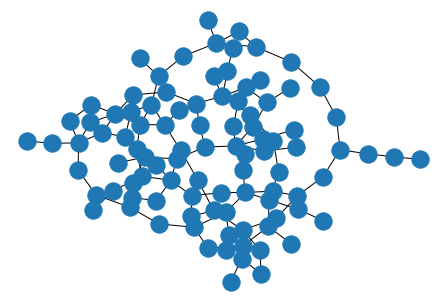

In [21]:
iterations = 5
losses = []
folder_name = f'{config["test"]["name"]}_iterative_test'
for test_idx in tqdm(range(10000, len(G_list))):
    G_vis = G_list[test_idx]
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')
    for i in range(iterations):
        node_pos, loss = evaluate(model, data_list[test_idx], criterion, device) 
        data_list[test_idx].x = torch.tensor(node_pos,dtype=torch.float)
    losses += [loss]
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_iter_model_{test_idx}_{loss}.png')

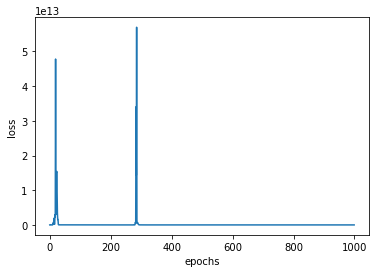

In [174]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()

In [10]:
np

3.3333333333333335

In [24]:
from tqdm.notebook import tqdm

In [32]:
with tqdm(total=10000000) as progress:
    for i in range(3):
        progress.reset()
        progress.set_description(desc=f"epoch {i}")
        for j in range(10000000):
            progress.update(1)